# Project Portfolio: Emergency Department Admission Classification #

This is a data science portfolio for upcoming DSDA conference in May 25, 2018. The dataset used was a simulated proprietary dataset from University of Toronto IHPME institution "Big Data Analytics for Healthcare" course offered in 2015.

** Problem Statement: ** emergency department (ED) visit is a fast wast of getting a hospital admission especially during weekends and holidays. However, not every patient requires an immediate ED admission. Thus, case prioritization based on severity of patient's condition within ED units has been a real struggle for the health care system. In this simulation study, a random set of patients who attended ED visits and their ED admission records were stored. 

The ED admission dataset contained various kind of features. These include demographic factors (i.e., distance, avg. income, gender, ethnicity), diagnostic factors (i.e., referral diagnosis code, tests, pain score, nausia score) and patient medical history (i.e., medications taken and family history).

** Stakeholders: ** 
ED unit managers, clinician groups, medical insurer and caregivers.

** Goal: ** 
To improve ED admission case prioritization using a classification model (facilitate management of ED patient flow)
* Reduce ED visits volume
* Improve ED wait time

** Results: ** 
94% of accurate predictions were made on a test set of ED patient population using the XGBoost classifier.

** Risks: ** 
Model incorrectly identified with 6% of error rate (especialy 2% error being false negatives (i.e., Type II error)).

** Mitigation: ** 
Reviewed identified error cases with subject matter experts before clinical decision making.

** Future Work: ** 
* Resampling strategies: SMOTE, upsamping (miniority class label: ED admitted cases) and etc.
* Model improvements: stacking, boosting or bagging (other ensemble models)
* Model design: using feature engineering to generate GP visits stratified classifiers (low vs. high GP visits).

** Recommendation for clients: **

1) Implement case prioritization guideline based on analytic insights
* GP visits: non-admitted patients have 5 times higher GP visits than ED admitted patients
* MRI counts: non-admitted patients have 7 times higher MRI exams done than ED admitted patients
* Previous medicaiton: non-admitted patients have 5 times higher medications taken than ED admitted patients

2) Setup alternative transfer: non-urgent cases
* For non-urgent cases, need to setup alternative transfer locations other than ED (i.e., walk-in clinics, etc.)

3) Data collection and integration
* Need for integration of EMR and administrative data in one data warehouse/storage.
* Feature selection: triage category (i.e., severity of conditions), hours after admission in past history, etc.

4) Conduct pilot study at institutional level
* Develop a proof of concept ML model and ML pipeline for the model deployment. 
* Required a strong support from analytics champion to transform organization and benefit realization.

## Part A. Data Wrangling ##
A Dataset required data cleansing and metadata formatting. Dataset was loaded onto Python as a dataframe. Dataset presented with a couple of problems such as missing data, outliers and imbalanced classes. In order to clean our dataset and prepared for classification modeling, data cleaning processes were executed. Processes were performed in a following order: feature imputation --> handling outliers --> format metadata types --> feature transformation (i.e., feature encoding). Once dataset was prepared, data exploration and machine learning model buidling exercises were performed.

In [1]:
###############################################################################
# ED Admission Data Wrangling #
###############################################################################
# Importing the libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import operator
from matplotlib.colors import ListedColormap
from itertools import cycle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy import interp
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm
#import sklearn.base as base

# Read train data:
df = pd.read_csv('ED_train.csv')
# Print top 5 observations:
print(df.head())
# Print dataframe shape:
print(df.shape)

# Drop unnecessary column: 'key'
df = df.drop(['Key'], axis=1)

# Check drop duplicates: 
df = df.drop_duplicates()
# Print dataframe shape: drop 923 rows
print(df.shape)

    Key  Gender Ethnicity LIHN  Avg_Income  Distance Admission_Date  \
0  1821     1.0         C    8         NaN       NaN     11/17/2013   
1  2018     0.0         C    N         NaN       NaN       5/6/2012   
2  2176     1.0         A    8         NaN       NaN     12/15/2013   
3  2719     1.0         C    N         NaN       NaN      4/25/2013   
4  2734     1.0         O    N         NaN       NaN       1/8/2014   

   GP_Visits  ED_Visits  Specialist_Visits  ...    Symptom2Visit_Days  Test_A  \
0          1          0                  0  ...                    10       N   
1          7          1                  0  ...                    28       N   
2          1          0                  0  ...                     9       N   
3          6          0                  0  ...                    17       N   
4          1          0                  0  ...                     8       N   

     Test_B   Test_C    Test_D Test_E  Test_F  Test_G  Test_H  Admit  
0  0.157895  0.

### Check # of missing value counts and percentage ###

In [2]:
# Check number of missing values and datatypes in dataframe:
#df.info()

# Compute missing value stat.: pre-data cleansing
ED_missing = df.isnull().sum()
ED_missing = pd.DataFrame(ED_missing)
ED_missing.columns = ['missing_value_counts']
ED_missing['missing_PCT'] = (ED_missing['missing_value_counts']/len(df))*100
 
# sort values by missing percent(%):
ED_missing = ED_missing.sort_values(by='missing_PCT',ascending=False)
ED_missing

,missing_value_counts,missing_PCT
Nausia_Score,50017,77.411317
Referral_Diagnosis_2,46887,72.567015
Test_H,45358,70.200582
Referral_Diagnosis_1,33053,51.156132
Avg_Income,14550,22.519037
Ethnicity,13512,20.912524
Distance,13485,20.870736
GP_Code,11080,17.148517
Gender,2743,4.245341
Test_G,107,0.165604


First of all, there were couple of features missing more than 50% of data (threshold). 
These features need to be removed from the entire dataset.

Numerical feature(s) with missing values:
* Avg_Income: 22.5%
* Distance: 20.9%

Categorical feature(s) with missing values:
* Ethnicity: 20.9%
* GP_Code: 17.1%
* Gender: 4.24%
* Test_G: 0.16%

### Compute Summary Statistics: pre-data cleansing ###
Computer summary statistics and report on numerical features only!

In [3]:
# Compute summary stat.: pre-data cleansing #
###############################################################################
# Note: NO stats computed for categorical variables (nominal & ordinal features)
ED_summary_pre = df.describe().T
# Reorder columns in following order: count to std
ED_summary_pre = ED_summary_pre[['count','min','max','mean','25%','50%','75%','std']]
# Drop all categorical features: keep only numerical
ED_summary_pre = ED_summary_pre.drop(['Gender','Allergy','Family_History',
                              'Test_B','Test_C','Test_D','Admit'])
# Print summary stat:
ED_summary_pre

,count,min,max,mean,25%,50%,75%,std
Avg_Income,50062.0,7117.000000,200001.000000,48016.687168,32474.000000,43125.000000,58257.000000,20693.475138
Distance,51127.0,0.417124,4798.898626,385.668065,112.879164,176.245146,529.964132,413.693007
GP_Visits,64612.0,0.000000,56.000000,1.233734,0.000000,1.000000,1.000000,1.699228
ED_Visits,64612.0,0.000000,8.000000,0.350771,0.000000,0.000000,1.000000,0.550946
Specialist_Visits,64612.0,0.000000,9.000000,0.556878,0.000000,0.000000,1.000000,0.652588
Hospital_Admissions,64612.0,0.000000,5.000000,0.041509,0.000000,0.000000,0.000000,0.228201
Total_Visits,64612.0,1.000000,58.000000,2.182938,1.000000,2.000000,2.000000,1.888086
MRI_Count,64612.0,0.000000,2.000000,0.036510,0.000000,0.000000,0.000000,0.192927
Pain_Score,64612.0,1.000000,5.000000,4.105460,3.000000,5.000000,5.000000,1.433807
Nausia_Score,14595.0,1.000000,4.000000,2.773621,2.000000,2.000000,4.000000,0.953347


### Drop features with missing values more than 50% ###
It is important drop any features where missing values counts % is far greater than 50%. Even though these features can be imputed by missing value replacement, it will not provide meaningful insights rather offer undesirable biased results.

In [4]:
# Drop features where missing_pct (%) > 50%:
###############################################################################
# Boolean which feature are missing more than 50%:
print(ED_missing['missing_PCT'] > 50)

# Drop 4 features with more than 50% missing values:
df = df.drop(['Referral_Diagnosis_1','Referral_Diagnosis_2','Nausia_Score','Test_H'], axis=1)

# Check dataframe:
df.info()

Nausia_Score             True
Referral_Diagnosis_2     True
Test_H                   True
Referral_Diagnosis_1     True
Avg_Income              False
Ethnicity               False
Distance                False
GP_Code                 False
Gender                  False
Test_G                  False
Test_A                  False
Test_C                  False
Test_B                  False
Family_History          False
Test_D                  False
Test_E                  False
Test_F                  False
Symptom2Visit_Days      False
Pain_Score              False
Previous_Medication     False
Allergy                 False
MRI_Count               False
Total_Visits            False
Hospital_Admissions     False
Specialist_Visits       False
ED_Visits               False
GP_Visits               False
Admission_Date          False
LIHN                    False
Admit                   False
Name: missing_PCT, dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64612 entries, 0 to

### Handling outliers with inter-quartile range (IQR) method ###
Outliers are the values that might potentialy skew the results on our modeling. In order to maximize the performance of classification model(s), it is required to handle outliers first. In a training set, there are 14 numerical features and a outlier detection dataframe was created. Easily, it was easy to identify there were outlier(s) in "distance" and "avg. income". The maximum value on each of feature is greater than the upper bound value computed IQR method. 

Outliers were required to be managed properly on these numerical features. In a training set, there were 10 independent features (i.e., continuous). These included “avg_income”, “distance” and etc. Interquartile range (IQR) method applied here. For example, if any value of a feature sits below lower and above upper bounds of IQR, these observations will be removed from dataset.

**IQR is defined as: IQR = Q3 – Q1 in which Q3 is 75th percentile and Q1 is 25th percentile of a feature. Lower bound (LB) equals to Q1 – (1.5 x IQR) and upper bound (UB) equals to Q3 + (1.5 x IQR)**.

From above definition, summary table was computed on all three numerical features. We can observed that the max. value on each of feature is greater than the upper bound value for avg_income, distance etc. 

In [5]:
# Handling outliers #
# Compute IQR, LowerBound and UpperBound
ED_summary_pre['IQR'] = ED_summary_pre['75%'] - ED_summary_pre['25%'] 
ED_summary_pre['LB'] =  ED_summary_pre['25%'] - 1.5*ED_summary_pre['IQR']   
ED_summary_pre['UB'] =  ED_summary_pre['75%'] + 1.5*ED_summary_pre['IQR']

# Extract dataframe:
ED_outliers = ED_summary_pre[['LB','min','UB','max']]
print(ED_outliers)

# How many features have outliers from Upper Bound (TRUE): 10 features
print(ED_outliers['UB'] < ED_outliers['max'])

# How many features have outliers from Lower Bound (TRUE): 1 feature
print(ED_outliers['LB'] > ED_outliers['min'])

                              LB          min            UB            max
Avg_Income          -6200.500000  7117.000000  96931.500000  200001.000000
Distance             -512.748287     0.417124   1155.591583    4798.898626
GP_Visits              -1.500000     0.000000      2.500000      56.000000
ED_Visits              -1.500000     0.000000      2.500000       8.000000
Specialist_Visits      -1.500000     0.000000      2.500000       9.000000
Hospital_Admissions     0.000000     0.000000      0.000000       5.000000
Total_Visits           -0.500000     1.000000      3.500000      58.000000
MRI_Count               0.000000     0.000000      0.000000       2.000000
Pain_Score              0.000000     1.000000      8.000000       5.000000
Nausia_Score           -1.000000     1.000000      7.000000       4.000000
Previous_Medication     0.000000     0.000000      0.000000       3.000000
Symptom2Visit_Days     -8.000000     3.000000     48.000000     228.000000
Test_E                 -4

* From Upper Bound perspective, presence of outliers were detected on 10 numerical features: avg_income, distance, etc.
* From Lower Bound perspective, presence of outliers were detected on 1 numerical feature: "Test_H".

### Removal of outliers and drop useless feature ###
Before remove outliers on these two features, test how many observations are affected.
This is critical because while removing outliers we want to preserve positive "ED admitted" samples as many as possible. More true positive cases you have, better for training a model and make good predictions on future incoming ED admission patient cases.

In [6]:
# Test: count how many outliers will be removed 
# Avg_Income: drop = 1541 rows
print(df[df['Avg_Income'] > ED_outliers.loc['Avg_Income']['UB']].index.shape)
# Distance: drop = 3940 rows
print(df[df['Distance'] > ED_outliers.loc['Distance']['UB']].index.shape)
# GP_Visits: drop = 8804 rows 
print(df[df['GP_Visits'] > ED_outliers.loc['GP_Visits']['UB']].index.shape)

# Distance: drop = 3940 rows
df = df.drop(df[df['Distance'] > ED_outliers.loc['Distance']['UB']].index)

(1541,)
(3940,)
(8804,)


### Feature Encoding ###
Feature encoding is a process where feature are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female). 

** Nominal feature encoding: ** allergy and previous_medication.
These two feature(s) have meaning of different class labels being "Yes" or "No" but already pre-encoded as numerical value(s) being "1" or "0". The main reason why these feature getting re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent and convert for easier interpretation when perfoming data exploration like a string value of "Yes" or "No".

In [7]:
###########################
# Nominal feature encoding:
###########################
# Define manual map: Gender_map
Gender_map = {0:'Female', 1:'Male'}
# Define manual map: Yes_No_map
Yes_No_map = {0:'No', 1:'Yes'}

# Inverse transform back to original value map:
inv_Gender_map = {v: k for k, v in Gender_map.items()}
inv_Yes_No_map = {v: k for k, v in Yes_No_map.items()}

** Ordinal feature encoding: ** admission_date. 
Admission date is a feature where it has a order of admission date from year 2009 to 2014. Thus, Admission date gets mapped into numerical values. For checking format of data consistency, we will print transformed admission date.

In [8]:
###########################
# Ordinal feature encoding:
###########################
# Admission_Date #
###############################################################################
df['Admission_Date'] = pd.to_datetime(df['Admission_Date'], format='%m/%d/%Y')
df['Admission_Date'].sort_values(ascending=True)

adm_date_mapping = {label:idx for idx, label in
                 enumerate (np.unique(df['Admission_Date']))}

# Use adm_date_mapping to transform the Admission_Date into integers:
df['Admission_Date'] = df['Admission_Date'].map(adm_date_mapping)
print(df['Admission_Date'].head())

# Reverse key-value pairs in the mapping dictionary:
inv_class_mapping = {v: k for k, v in adm_date_mapping.items()}

0    905
1    498
2    925
3    759
4    942
Name: Admission_Date, dtype: int64


### Data Splits & Feature Transformation ###
First, dataset was split into a set of input features and an output label (i.e., admit). Secondly, feature imputation step was performed to replace any missing values on different data types (i.e., continuous and ordinal feature). For example, "Avg_Income" and "GP_Code" were replaced by median and mode respectively. Finally, metadata formatting was done to ensure each feature for having a correct data type.

In [9]:
###########################
# Feature Imputation:
###########################
# Ethnicity:
###############################################################################
df_Ethnicity_count = df['Ethnicity'].value_counts().sort_values(ascending=False)
# counts=22041, Mode = 'C'

# GP_Code:
###############################################################################
df_GPCode_count = df['GP_Code'].value_counts().sort_values(ascending=False)
# counts=216, Mode = '441471'

# Test_G:
###############################################################################
df_Test_G_count = df['Test_G'].value_counts().sort_values(ascending=False)
# Mode = 'CIP', counts=12698

# Missing Value Replacement: Nominal Features
df['Ethnicity'] = df['Ethnicity'].fillna('C')
df['GP_Code'] = df['GP_Code'].fillna('441471')
df['Test_G'] = df['Test_G'].fillna('CIP')

In [10]:
# Specify inputs and output label:
X, y = df.iloc[:, :-1], df['Admit']

# Check input features and output label:
print(X.head())
print(y.head())

# Missing value check:
df.isnull().sum()

   Gender Ethnicity LIHN  Avg_Income  Distance  Admission_Date  GP_Visits  \
0     1.0         C    8         NaN       NaN             905          1   
1     0.0         C    N         NaN       NaN             498          7   
2     1.0         A    8         NaN       NaN             925          1   
3     1.0         C    N         NaN       NaN             759          6   
4     1.0         O    N         NaN       NaN             942          1   

   ED_Visits  Specialist_Visits  Hospital_Admissions   ...    \
0          0                  0                    0   ...     
1          1                  0                    0   ...     
2          0                  0                    0   ...     
3          0                  0                    0   ...     
4          0                  0                    0   ...     

   Previous_Medication  Family_History Symptom2Visit_Days  Test_A    Test_B  \
0                    1               1                 10       N  0.1578

Gender                  2516
Ethnicity                  0
LIHN                       0
Avg_Income             14467
Distance               13485
Admission_Date             0
GP_Visits                  0
ED_Visits                  0
Specialist_Visits          0
Hospital_Admissions        0
Total_Visits               0
MRI_Count                  0
GP_Code                    0
Pain_Score                 0
Allergy                    0
Previous_Medication        0
Family_History             0
Symptom2Visit_Days         0
Test_A                     0
Test_B                     0
Test_C                     0
Test_D                     0
Test_E                     0
Test_F                     0
Test_G                     0
Admit                      0
dtype: int64

In [11]:
# Dropped features for index
###############################################################################
# Column index = 16, Nausia_Score (dropped)
# Column index = 28, Test_H (dropped)

# Feature Imputation #
###############################################################################
# Imputation: avg_income, distance (scale feature) by median
# Column index = 3,4
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis=0)
imputer = imputer.fit(X.iloc[:, 3:5])
X.iloc[:,3:5] = imputer.transform(X.iloc[:, 3:5])

# Imputation: gender (categorical feature) by mode
# Column index = 0
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)
imputer = imputer.fit(X.iloc[:, 0:1])
X.iloc[:,0:1] = imputer.transform(X.iloc[:, 0:1])

In [12]:
# Prepare cleansed dataframe:
# Concatenated cleaned inputs and output label as a new dataframe:
df_cleaned = pd.concat([X, y], axis=1)

# Check any missing values on a new dataframe:
print(df_cleaned.isnull().sum())

# Convert data types for cleaned dataframe:
df_cleaned['Ethnicity'] = df_cleaned['Ethnicity'].astype('category')
df_cleaned['LIHN'] = df_cleaned['LIHN'].astype('category')
df_cleaned['GP_Code'] = df_cleaned['GP_Code'].astype('category')
df_cleaned['Test_A'] = df_cleaned['Test_A'].astype('category')
df_cleaned['Test_F'] = df_cleaned['Test_F'].astype('category')
df_cleaned['Test_G'] = df_cleaned['Test_G'].astype('category')

# Check data type:
df_cleaned.info()

Gender                 0
Ethnicity              0
LIHN                   0
Avg_Income             0
Distance               0
Admission_Date         0
GP_Visits              0
ED_Visits              0
Specialist_Visits      0
Hospital_Admissions    0
Total_Visits           0
MRI_Count              0
GP_Code                0
Pain_Score             0
Allergy                0
Previous_Medication    0
Family_History         0
Symptom2Visit_Days     0
Test_A                 0
Test_B                 0
Test_C                 0
Test_D                 0
Test_E                 0
Test_F                 0
Test_G                 0
Admit                  0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60672 entries, 0 to 65534
Data columns (total 26 columns):
Gender                 60672 non-null float64
Ethnicity              60672 non-null category
LIHN                   60672 non-null category
Avg_Income             60672 non-null float64
Distance               60672 non-null floa

In [13]:
# Keep df_cleaned dataframe for Exploratory Data Analysis (EDA) #
###############################################################################
# Encode features on Gender, Allergy, Family_History:
df_cleaned['Gender'] = df_cleaned['Gender'].map(Gender_map)
df_cleaned['Allergy'] = df_cleaned['Allergy'].map(Yes_No_map)
df_cleaned['Family_History'] = df_cleaned['Family_History'].map(Yes_No_map)

# Encode admission date back to original format:
df_cleaned['Admission_Date'] = df_cleaned['Admission_Date'].map(inv_class_mapping)

# Check final dataframe format:
df_cleaned.head()

# Save ED cleaned dataframe:
df_cleaned.to_csv('ED_train_cleaned.csv')

## Part B. Exploratory Data Analysis ##

### EDA: cleaned train set ###
Data exploration is conducted on cleaned entire train set. The main goal of this phase is to explore any interesting relationships among features and identify which feature has a clear impact on predicting ED admitted cases over an ED non-admitted patient. 

Following set of questions are asked:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tells a compelling story about ED admission classification dataset.

In [14]:
# Check number of missing values:
df_cleaned.isnull().sum()

# Check drop duplicates: drop 288 rows
df_cleaned = df_cleaned.drop_duplicates()

In [15]:
###############################################################################
# Part B: Exploratory Data Analysis #
###############################################################################
# Compute summary stat.: post-data cleansing 
ED_summary_post = df_cleaned.describe().T
# Reorder columns order in summary dataframe
ED_summary_post = ED_summary_post[['count','min','max','mean','25%','50%','75%','std']]
# drop non-numerical and meaningless features
ED_summary_post = ED_summary_post.drop(['Admit'])
ED_summary_post

,count,min,max,mean,25%,50%,75%,std
Avg_Income,60445.0,7117.000000,200001.000000,46108.785044,35135.000000,42247.000000,51937.000000,17867.803347
Distance,60445.0,0.417124,1154.751207,271.549125,139.897041,168.112133,314.192042,251.139804
GP_Visits,60445.0,0.000000,56.000000,1.254115,0.000000,1.000000,2.000000,1.720545
ED_Visits,60445.0,0.000000,8.000000,0.357730,0.000000,0.000000,1.000000,0.556273
Specialist_Visits,60445.0,0.000000,9.000000,0.555679,0.000000,0.000000,1.000000,0.656159
Hospital_Admissions,60445.0,0.000000,5.000000,0.042121,0.000000,0.000000,0.000000,0.230620
Total_Visits,60445.0,1.000000,58.000000,2.209695,1.000000,2.000000,3.000000,1.918329
MRI_Count,60445.0,0.000000,2.000000,0.037456,0.000000,0.000000,0.000000,0.195543
Pain_Score,60445.0,1.000000,5.000000,4.086872,3.000000,5.000000,5.000000,1.445482
Previous_Medication,60445.0,0.000000,3.000000,0.055075,0.000000,0.000000,0.000000,0.244781


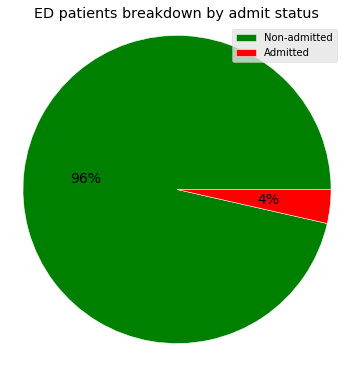

In [16]:
# Group dataframe by ED admit status:
def grp_df_admit(x):
    df_grp_admit = pd.DataFrame(df_cleaned.groupby(x)[x].count())
    df_grp_admit.columns = ['count']
    return df_grp_admit

# Grouped dataframe by ED admit status:
df_grp_admit = grp_df_admit('Admit')

# Function: plot a pie chart
def pie_plot(x,y,c):
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.pie(x, colors = c, autopct='%.0f%%', startangle=0,
           wedgeprops = {'edgecolor':'white'}, textprops={'fontsize':14})
    plt.legend(labels = y, loc='upper right')
    plt.axis('equal')
    plt.tight_layout()

# Plot a pie chart patients breakdown by ED admit status:
pie_plot(df_grp_admit, ['Non-admitted','Admitted'], ['green','red'])
plt.title('ED patients breakdown by admit status')
plt.show()

### Create data frames: grouping on ED admit flag by demographics and diagnostic factors ###

In [17]:
# Group dataframe by ED admit status:
def grp_df(x,y):
    df_grp = pd.DataFrame(df_cleaned.groupby([y,x])[x].count())
    df_grp.columns = ['count']
    return df_grp

# Count frequencies: demographic factors on ED admission
###############################################################################    
df_grp_gender = grp_df('Gender','Admit')
df_grp_ethnicity = grp_df('Ethnicity','Admit')

# Count frequencies: health monitoring metrics/indicators on ED admission
###############################################################################
df_grp_allergy = grp_df('Allergy','Admit')
df_grp_fam_history = grp_df('Family_History','Admit')
df_grp_med = grp_df('Previous_Medication','Admit')
df_grp_pain = grp_df('Pain_Score','Admit')
df_grp_gp_visits = grp_df('GP_Visits','Admit')
df_grp_ed_visits = grp_df('ED_Visits','Admit')
df_grp_mri_cnt = grp_df('MRI_Count','Admit')
df_grp_hosp_adm = grp_df('Hospital_Admissions','Admit')

### Frequency counts ED admitted vs non-admitted: by demographic & diagnostic factors ###

In [18]:
# Function: split a class label and calculate % proportion:
def df_grp_split(x):
    df_grp_0 = x.loc[0]
    df_grp_1 = x.loc[1]
#    df_grp_0['pct'] = (df_grp_0/df_grp_0.sum())*100    
#   df_grp_1['pct'] = (df_grp_1/df_grp_1.sum())*100
    return (df_grp_0, df_grp_1)

# Function: plot a pie chart with two subplots
def pie_subplots(x1,x2,y,var,c):
    f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    # 1st subplot:
    ax1.pie(x1, colors = c, autopct='%.0f%%', startangle=0,
           wedgeprops = {'edgecolor':'white'}, textprops={'fontsize':14})
    ax1.legend(labels = y, loc='upper right')
    ax1.set_title('ED non-admitted by ' + var, fontsize=13)
    # 2nd subplot:
    ax2.pie(x2, colors = c, autopct='%.0f%%', startangle=0,
           wedgeprops = {'edgecolor':'white'}, textprops={'fontsize':14})
    ax2.legend(labels = y, loc='upper right')
    ax2.set_title('ED admitted by ' + var, fontsize=13)

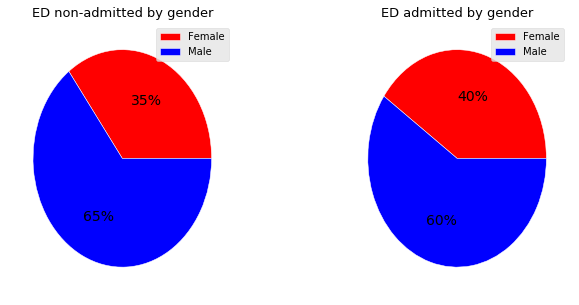

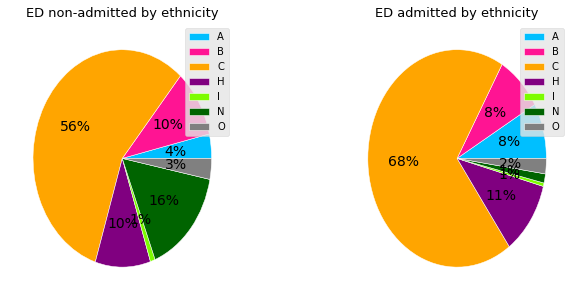

In [19]:
# Split dataframe grouped by gender:
df_grp_gender_0, df_grp_gender_1 = df_grp_split(df_grp_gender)
# Split dataframe grouped by ethnicity:
df_grp_ethnicity_0, df_grp_ethnicity_1 = df_grp_split(df_grp_ethnicity)

plt.figure()
# Plot a pie chart breakdown by gender for ED admitted vs non-admitted:
pie_subplots(df_grp_gender_0, df_grp_gender_1, df_grp_gender_0.index, 
             'gender', ['red','blue'])
plt.show()
# Plot a pie chart breakdown by ethnicity for ED admitted vs non-admitted:
pie_subplots(df_grp_ethnicity_0, df_grp_ethnicity_1, df_grp_ethnicity_0.index, 
             'ethnicity', ['deepskyblue','deeppink','orange',
                           'purple','lawngreen','darkgreen','gray'])
plt.show()

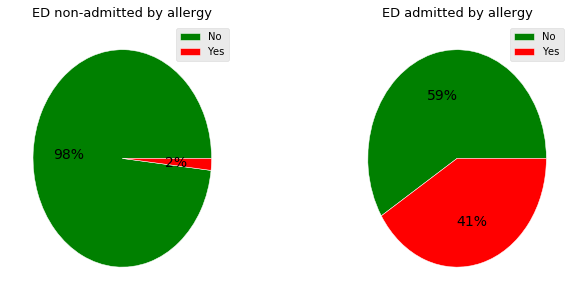

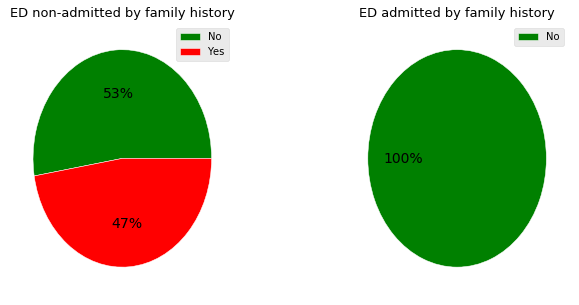

In [20]:
# Split dataframe grouped by allergy:
df_grp_allergy_0, df_grp_allergy_1 = df_grp_split(df_grp_allergy)
# Split dataframe grouped by family history:
df_grp_fam_history_0, df_grp_fam_history_1 = df_grp_split(df_grp_fam_history)

plt.figure()
# Plot a pie chart breakdown by allergy for ED admitted vs non-admitted:
pie_subplots(df_grp_allergy_0, df_grp_allergy_1, df_grp_allergy_0.index, 
             'allergy', ['green','red'])
plt.show()
# Plot a pie chart breakdown by family history for ED admitted vs non-admitted:
pie_subplots(df_grp_fam_history_0, df_grp_fam_history_1, df_grp_fam_history_0.index, 
             'family history', ['green','red'])
plt.show()

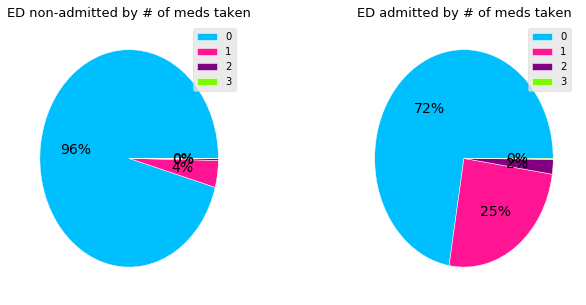

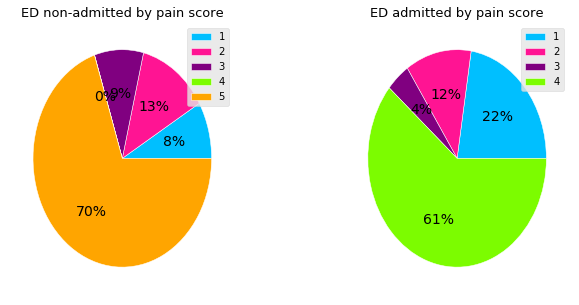

In [21]:
# Split dataframe grouped by medications:
df_grp_med_0, df_grp_med_1 = df_grp_split(df_grp_med)
# Split dataframe grouped by pain score:
df_grp_pain_0, df_grp_pain_1 = df_grp_split(df_grp_pain)

plt.figure()
# Plot a pie chart breakdown by medications for ED admitted vs non-admitted:
pie_subplots(df_grp_med_0, df_grp_med_1, df_grp_med_0.index, 
             '# of meds taken', ['deepskyblue','deeppink','purple','lawngreen'])
plt.show()
# Plot a pie chart breakdown by pain score for ED admitted vs non-admitted:
pie_subplots(df_grp_pain_0, df_grp_pain_1, df_grp_pain_0.index, 
             'pain score', ['deepskyblue','deeppink','purple','lawngreen','orange'])
plt.show()

In [22]:
# Split dataframe grouped by GP visits:
df_grp_gp_visits_0, df_grp_gp_visits_1 = df_grp_split(df_grp_gp_visits)

# Proportion: only non-ED admitted cases by GP visits
df_grp_gp_visits_0['pct'] = (df_grp_gp_visits_0/df_grp_gp_visits_0.sum())*100
print('non-ED admitted population', df_grp_gp_visits_0['pct'].sort_values(ascending=False))

# Proportion: only ED admitted cases by GP visits
df_grp_gp_visits_1['pct'] = (df_grp_gp_visits_1/df_grp_gp_visits_1.sum())*100
print('ED admitted population', df_grp_gp_visits_1['pct'].sort_values(ascending=False))

non-ED admitted population GP_Visits
0     39.133120
1     38.302945
2     11.349720
3      4.909007
4      2.636318
5      1.581448
6      0.909075
7      0.523147
8      0.322464
9      0.154371
10     0.104629
11     0.039450
12     0.017152
13     0.006861
15     0.003430
18     0.001715
14     0.001715
17     0.001715
56     0.001715
Name: pct, dtype: float64
ED admitted population GP_Visits
5     16.604478
4     14.598881
6     12.873134
3     11.473881
7     11.380597
8      9.421642
2      7.229478
9      5.270522
10     3.917910
1      2.845149
11     2.145522
12     0.839552
13     0.559701
14     0.513060
0      0.093284
15     0.093284
19     0.046642
17     0.046642
21     0.046642
Name: pct, dtype: float64


In [23]:
# Split dataframe grouped by GP visits:
df_grp_ed_visits_0, df_grp_ed_visits_1 = df_grp_split(df_grp_ed_visits)

# Proportion: only non-ED admitted cases by ED visits
df_grp_ed_visits_0['pct'] = (df_grp_ed_visits_0/df_grp_ed_visits_0.sum())*100
print('non-ED admitted population', df_grp_ed_visits_0['pct'].sort_values(ascending=False))

# Proportion: only ED admitted cases by ED visits
df_grp_ed_visits_1['pct'] = (df_grp_ed_visits_1/df_grp_ed_visits_1.sum())*100
print('ED admitted population', df_grp_ed_visits_1['pct'].sort_values(ascending=False))

non-ED admitted population ED_Visits
0    68.043430
1    29.112708
2     2.584861
3     0.226411
4     0.025729
5     0.005146
8     0.001715
Name: pct, dtype: float64
ED admitted population ED_Visits
0    59.328358
1    30.037313
2     8.535448
3     1.679104
4     0.279851
5     0.139925
Name: pct, dtype: float64


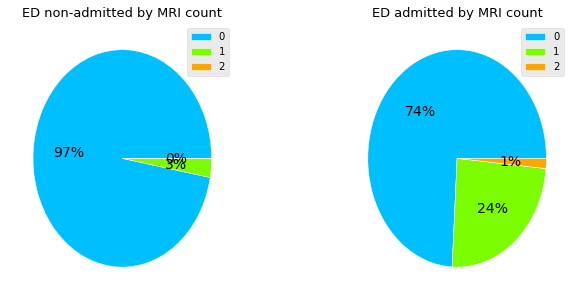

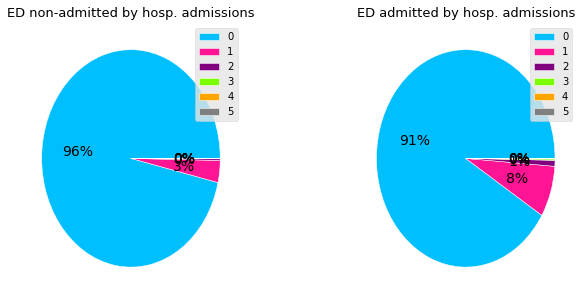

In [24]:
# Split dataframe grouped by MRI count:
df_grp_mri_cnt_0, df_grp_mri_cnt_1 = df_grp_split(df_grp_mri_cnt)
# Split dataframe grouped by hospital admissions:
df_grp_hosp_adm_0, df_grp_hosp_adm_1 = df_grp_split(df_grp_hosp_adm)

plt.figure()
# Plot a pie chart breakdown by MRI count for ED admitted vs non-admitted:
pie_subplots(df_grp_mri_cnt_0, df_grp_mri_cnt_1, df_grp_mri_cnt_0.index, 
             'MRI count', ['deepskyblue','lawngreen','orange'])
plt.show()
# Plot a pie chart breakdown by hospital admissions for ED admitted vs non-admitted:
pie_subplots(df_grp_hosp_adm_0, df_grp_hosp_adm_1, df_grp_hosp_adm_0.index, 
             'hosp. admissions', ['deepskyblue','deeppink','purple','lawngreen','orange','gray'])
plt.show()

***Histogram: Continous Varaibles***

Distribution of avg_income, distance and symptom to visit days on patient population. Distributions were plotted separately on same kind of figure for each group of ED admit and ED non-admit population.

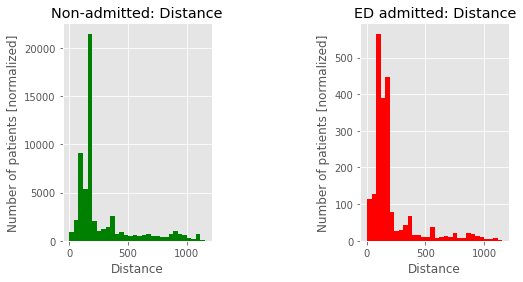

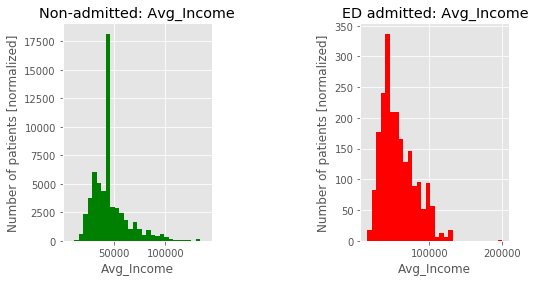

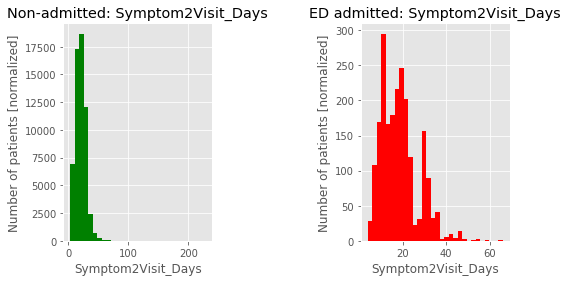

In [25]:
# Grouped dataframe by admit label:
# ag = df_cleaned.groupby('Admit')

# Split dataframe by admit status:
df_admit_0 = df_cleaned[df_cleaned['Admit'] == 0] # only ED non-admitted patients
df_admit_1 = df_cleaned[df_cleaned['Admit'] == 1] # only ED admitted patients

# Write a function to plot histogram:
def plot_hist(x,bins,c1,c2):
    plt.figure(figsize=(8,4))
    plt.subplots_adjust(hspace=0.5, wspace=1.0)
    plt.subplot(1,2,1)
    df_admit_0[x].hist(bins=bins, color=c1)
    plt.title('Non-admitted: ' + x )
    plt.xlabel(x)
    plt.ylabel('Number of patients [normalized]')
    
    plt.subplot(1,2,2)
    df_admit_1[x].hist(bins=bins, color=c2)
    plt.title('ED admitted: ' + x)
    plt.xlabel(x)
    plt.ylabel('Number of patients [normalized]')

# Visualization: continuous/discrete - scale
###############################################################################
# Histogram: Distance
plot_hist('Distance', 30, 'green','red')
plt.show()

# Histogram: Avg_Income
plot_hist('Avg_Income',30, 'green','red')
plt.show()

# Histogram: Symptom2Visit_Days
plot_hist('Symptom2Visit_Days',30, 'green','red')
plt.show()

Summary of distributions by distance, avg_income and symptom to visit days
* Distance: distribution of distance on non-admitted population is skewed to right. Most of ED admitted patients seems to live closer to their admitted hospital locations. 
* Avg_Income: distribution of avg_income on non-admitted population is skewed to right. However, ED admitted population seems to show a bit more uniform distribution pattern than non-admitted population. 
* Symptom_to_visit_days: distribution of symptom to visit day on non-admitted population is extremely right skewed. As a lot of non-admitted patients seem to visit from 20-30 days. Interestingly, ED admitted population show a bit more uniform distribution pattern than non-admitted population.

### Correlation Matrix: Training Set ###

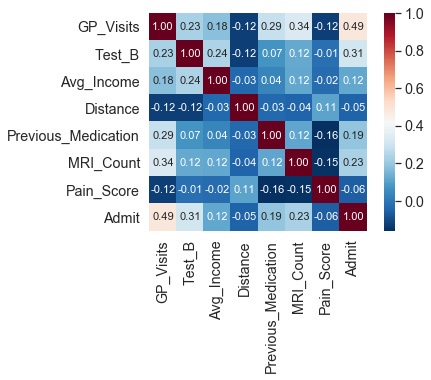

In [26]:
# Correlation Matrix Plot # entire dataset
###############################################################################
# Column names of cleaned dataframe
cols = ['GP_Visits', 'Test_B', 
        'Avg_Income', 'Distance', 
        'Previous_Medication', 'MRI_Count',
        'Pain_Score', 'Admit']

#'Avg_Income', 'Test_C', 'Test_D' 

# Plot correlation matrix heatmap
#plt.figure()
cm = np.corrcoef(df_cleaned[cols].values.T)
sns.set(font_scale = 1.3)
hm = sns.heatmap(cm, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':11}, yticklabels=cols, xticklabels=cols)
plt.show()

### Box-Whisker Plot: entire ED patient population (non-admitted vs ED admitted) ###

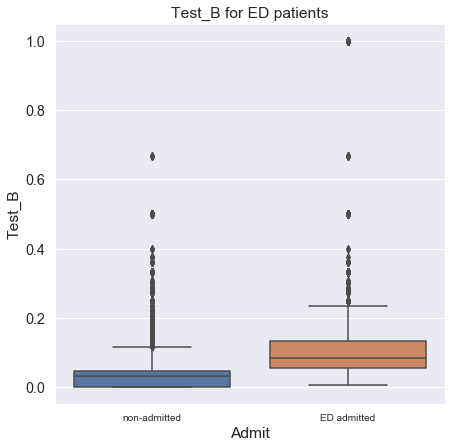

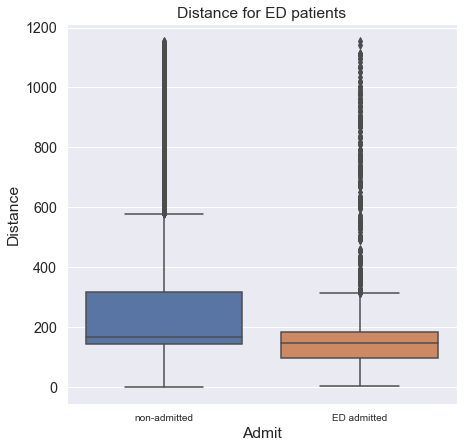

In [27]:
# Visualization: categorical and scale 
# Write a function for box-whisker plot:
def sns_box_plot(x,y,df):
    plt.figure(figsize=(7,7))
    sns.boxplot(x=x,y=y,data=df)
    lb = [0,1]
    labels=['non-admitted','ED admitted']
    plt.xticks(lb, labels, rotation=0, fontsize=10)
    plt.title(y + ' for ED patients')

# Box-Whisker Plot #
sns_box_plot('Admit', 'Test_B', df_cleaned)
plt.show()

sns_box_plot('Admit', 'Distance', df_cleaned)
plt.show()

### EDA: ED admitted patients only ###
### Correlation Matrix Plot: ED admitted patients ###

C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


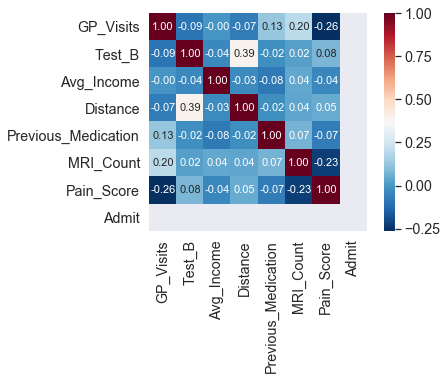

In [28]:
# Filtered dataframe by Admit label: '0':non-admitted, '1':admitted #
###############################################################################
df_admit_0 = df_cleaned[df_cleaned['Admit'] == 0] # only ED non-admitted patients
df_admit_1 = df_cleaned[df_cleaned['Admit'] == 1] # only ED admitted patients

# Correlation Matrix Plot #
# CM plot of ED admitted patients only:
plt.figure()
cm = np.corrcoef(df_admit_1[cols].values.T)
sns.set(font_scale = 1.3)
hm = sns.heatmap(cm, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':11}, yticklabels=cols, xticklabels=cols)
plt.show()

### Bar charts: number of ED patients by diagnostic factors 

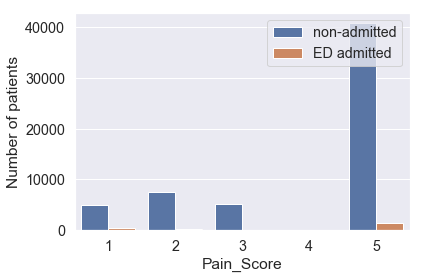

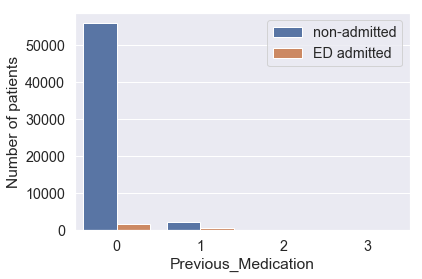

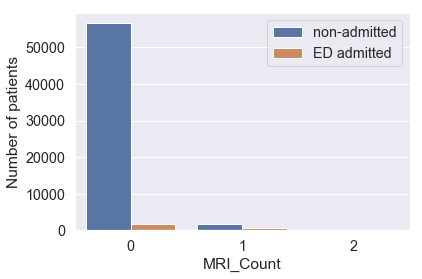

In [29]:
# Bar charts on health indicator factors on ED admitted patients #
# Write a function for countplot:
def sns_countplot(x,y,df):
    sns.countplot(x=x, hue=y, data=df)
    plt.ylabel('Number of patients')
    plt.legend(('non-admitted', 'ED admitted'), loc='upper right')

sns_countplot('Pain_Score', 'Admit', df_cleaned)
plt.show()

sns_countplot('Previous_Medication', 'Admit', df_cleaned)
plt.show()

sns_countplot('MRI_Count', 'Admit', df_cleaned)
plt.show()

### Bar charts: mean of diagnostic metrics on ED patients by admit status

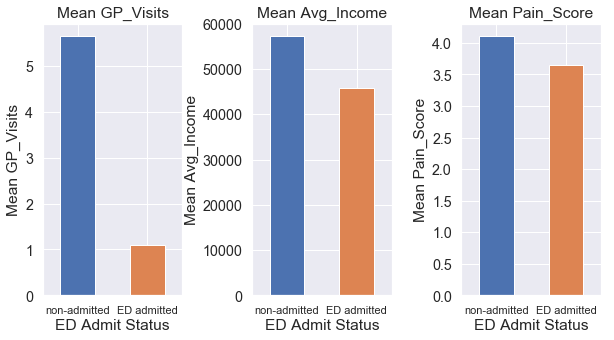

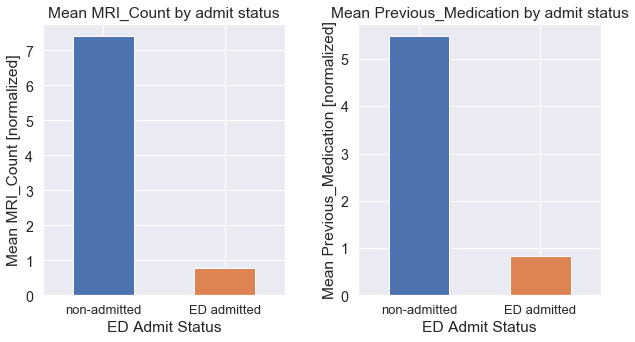

In [30]:
# Write a bar chart plot function:
def bar_plot(x1,x2,x3,y):
    # Convert labels into text label:
    lb = [0,1]
    labels=['non-admitted','ED admitted']
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace=0.5)
    # Mean GP visits:
    plt.subplot(1,3,1)
    df_cleaned.groupby(y)[x1].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=11)
    plt.xlabel('ED Admit Status')
    plt.ylabel('Mean '+ x1)
    plt.title('Mean ' + x1)
    # Mean avg. income:
    plt.subplot(1,3,2)
    df_cleaned.groupby(y)[x2].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=11)
    plt.xlabel('ED Admit Status')
    plt.ylabel('Mean '+ x2)
    plt.title('Mean ' + x2)
    # Mean pain score:
    plt.subplot(1,3,3)
    df_cleaned.groupby(y)[x3].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=11)
    plt.xlabel('ED Admit Status')
    plt.ylabel('Mean '+ x3)
    plt.title('Mean ' + x3)    

# Write a bar chart plot function [normalized mean]:    
def bar_norm_plot(x1,mu1,x2,mu2,y):
    # Convert labels into text label:
    lb = [0,1]
    labels=['non-admitted','ED admitted']
    plt.figure(figsize=(10,5)) 
    plt.subplots_adjust(wspace=0.3)
    # Normalized mean MRI count:
    plt.subplot(1,2,1)
    (df_cleaned.groupby(y)[x1].mean()/mu1).sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=13)
    plt.xlabel('ED Admit Status')
    plt.ylabel('Mean '+ x1 + ' [normalized]')
    plt.title('Mean ' + x1 + ' by admit status')
    # Normalized mean previous meds taken:
    plt.subplot(1,2,2)
    (df_cleaned.groupby(y)[x2].mean()/mu2).sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lb, labels, rotation=0, fontsize=13)
    plt.xlabel('ED Admit Status')
    plt.ylabel('Mean '+ x2 + ' [normalized]')
    plt.title('Mean ' + x2 + ' by admit status')
    
# Plot a bar chart: mean diagnostic metrics
bar_plot('GP_Visits','Avg_Income','Pain_Score','Admit')
plt.show()

# Plot a normalized bar chart: mean diagnostic metrics
bar_norm_plot('MRI_Count',0.037,
              'Previous_Medication',0.055,
              'Admit')
plt.show()

### Compute Summary Statistics: ED admitted vs non-admitted cases ###
Computer summary statistics and report on numerical features only!

In [31]:
# Compute summary statistics #
###############################################################################
# ED admitted patients only:
df_admit_1_stat = df_admit_1.describe().T
# Reorder columns order in summary dataframe
df_admit_1_stat = df_admit_1_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'Admit' column:
df_admit_1_stat = df_admit_1_stat.drop(['Admit'])
# Print summary stat.:
print(df_admit_1_stat)

# ED non-admitted patients only:
df_admit_0_stat = df_admit_0.describe().T
# Reorder columns order in summary dataframe
df_admit_0_stat = df_admit_0_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'Admit' column:
df_admit_0_stat = df_admit_0_stat.drop(['Admit'])
# Print summary stat.:
print(df_admit_0_stat)

                      count           min            max          mean  \
Avg_Income           2144.0  15058.000000  200001.000000  57192.554571   
Distance             2144.0      2.198764    1154.751207    208.923002   
GP_Visits            2144.0      0.000000      21.000000      5.642257   
ED_Visits            2144.0      0.000000       5.000000      0.539646   
Specialist_Visits    2144.0      0.000000       9.000000      0.610075   
Hospital_Admissions  2144.0      0.000000       5.000000      0.103545   
Total_Visits         2144.0      1.000000      28.000000      6.895522   
MRI_Count            2144.0      0.000000       2.000000      0.273787   
Pain_Score           2144.0      1.000000       5.000000      3.655784   
Previous_Medication  2144.0      0.000000       3.000000      0.301306   
Symptom2Visit_Days   2144.0      4.000000      66.000000     18.661847   
Test_B               2144.0      0.006211       1.000000      0.126746   
Test_C               2144.0      0.005

### Dealing with class imbalance problem on ED dataset ###
Class imbalance with low prevalence of true positive cases (i.e., ED admitted cases) are the most common problem in healthcare analytics for any classification problems. For example, in this ED dataset, 96% were non-admitted and only 4% were ED admitted cases. Thus, if class imbalance in the dataset is not handled properly, a classifier would ended up predicting "non-admitted" cases most of time. Therefore, even if the ML model's has high accuracy (due to true negative: non-admitted cases), the trained classifier is not going to be meaningful for making good prognosis (who need ED admissions).

Class imbalance adjustment is addressed here by executing random downsampling on population of non-admitted cases to match the sample size of ED admitted population. This will help builiding a classifier with equal proportion of classes (i.e., non-admitted and ED admitted) with higher prevalence (i.e., 50% of ED admitted cases present).

In [32]:
# Downsampling on non-admitted sample to match proportion of admitted cases:
######################################################################################
df_admit_0_downsampled = resample(df_admit_0, replace=True, 
                               n_samples=2144,random_state=0)

# Combine minority class '1': stroke patients with downsampled majority class:
df_downsampled = pd.concat([df_admit_0_downsampled,df_admit_1],axis=0)

# Check # of class label: admit vs. non-admit
df_downsampled['Admit'].value_counts()

1    2144
0    2144
Name: Admit, dtype: int64

After downsampling, the resampled dataset achieved an equal ratio of stroke and non-stroke cases with a sample size (n=4288)

### EDA: balanced dataset with negative sub-sampling (downsampled) ###
### Correlation Matrix Plot: ED admitted patients (downsampled) ###

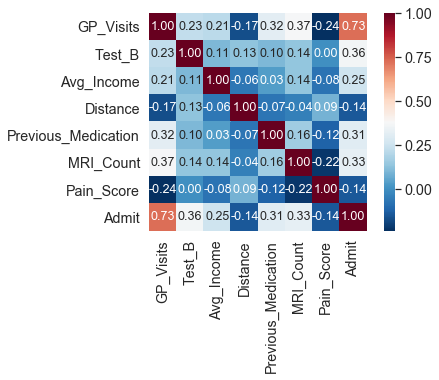

In [33]:
# Correlation Matrix Plot # random downsampled dataset (1:1 ratio)
###############################################################################
# CM plot of randomized downsampled dataset:
cm_downsampled = np.corrcoef(df_downsampled[cols].values.T)
sns.set(font_scale = 1.3)
hm = sns.heatmap(cm_downsampled, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':12.5}, yticklabels=cols, xticklabels=cols)
plt.show()

### Pearson Correlation: Balanced Dataset (downsampled) ###
To further explore a pair of relationships between GP_Visits and MRI_count, GP_Visits and Previous_Medication, GP_Visits and Test_D, Pearson's correlation coefficients were calculated on resampled dataset. Relationship(s) will be further explored by dividing data into two classes using admit status.

In [34]:
# Split GP_Visits, MRI_count, Previous_Medication and Test_D into different population groups:
# Non-admitted patients group: 
gp_visits_0 = df_downsampled[df_downsampled['Admit'] == 0]['GP_Visits']
prev_med_0 = df_downsampled[df_downsampled['Admit'] == 0]['Previous_Medication']
mri_count_0 = df_downsampled[df_downsampled['Admit'] == 0]['MRI_Count']
test_b_0 = df_downsampled[df_downsampled['Admit'] == 0]['Test_B']

# ED admitted patients group: 
gp_visits_1 = df_downsampled[df_downsampled['Admit'] == 1]['GP_Visits']
prev_med_1 = df_downsampled[df_downsampled['Admit'] == 1]['Previous_Medication']
mri_count_1 = df_downsampled[df_downsampled['Admit'] == 1]['MRI_Count']
test_b_1 = df_downsampled[df_downsampled['Admit'] == 1]['Test_B']

***Define Pearson Correlation Function***

In [35]:
def pearson_r(x,y):
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]

# Compute Pearson correlation coefficient: non ED admitted population
r1a = pearson_r(gp_visits_0, mri_count_0)
print('Pearson correlation of non ED admitted GP_Visits vs. MRI_Count: %.3f'% r1a)

r2a = pearson_r(gp_visits_0, prev_med_0)
print('Pearson correlation of non ED admitted GP_Visits vs. Prev_Med: %.3f'% r2a)

r3a = pearson_r(gp_visits_0, test_b_0)
print('Pearson correlation of non ED admitted GP_Visits vs. Test_B: %.3f'% r3a)

# Compute Pearson correlation coefficient: ED admitted population
r1b = pearson_r(gp_visits_1, mri_count_1)
print('Pearson correlation of ED admitted GP_Visits vs. MRI_Count: %.3f'% r1b)

r2b = pearson_r(gp_visits_1, prev_med_1)
print('Pearson correlation of ED admitted GP_Visits vs. Prev_Med: %.3f'% r2b)

r3b = pearson_r(gp_visits_1, test_b_1)
print('Pearson correlation of ED admitted GP_Visits vs. Test_B: %.3f'% r3b)

Pearson correlation of non ED admitted GP_Visits vs. MRI_Count: 0.281
Pearson correlation of non ED admitted GP_Visits vs. Prev_Med: 0.212
Pearson correlation of non ED admitted GP_Visits vs. Test_B: 0.135
Pearson correlation of ED admitted GP_Visits vs. MRI_Count: 0.200
Pearson correlation of ED admitted GP_Visits vs. Prev_Med: 0.127
Pearson correlation of ED admitted GP_Visits vs. Test_B: -0.090


## Part C. Machine Learning Modeling: Classification ##

### Dummy Variable Encoding: nominal features ###
Dummy variable encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted by ML models for making accurate predictions. Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: Ethinicty_Caucassian vs. Ethinicty_Asian).

In [36]:
# Encode features on Gender, Allergy, Family_History:
df_downsampled['Gender'] = df_downsampled['Gender'].map(inv_Gender_map)
df_downsampled['Allergy'] = df_downsampled['Allergy'].map(inv_Yes_No_map)
df_downsampled['Family_History'] = df_downsampled['Family_History'].map(inv_Yes_No_map)

# Encode admission date to ordinal format:
df_downsampled['Admission_Date'] = df_downsampled['Admission_Date'].map(adm_date_mapping)

# Check re-formatted on random down resampled dataframe:
print(df_downsampled.head())

# Check unique entities on following categorical features:
print(np.count_nonzero(df_downsampled['GP_Code'].unique()),'GPCode entities') 
print(np.count_nonzero(df_downsampled['LIHN'].unique()),'LIHN entities') 
print(np.count_nonzero(df_downsampled['Ethnicity'].unique()),'Ethnicity entities')
print(np.count_nonzero(df_downsampled['Test_A'].unique()),'Test_A entities') 
print(np.count_nonzero(df_downsampled['Test_F'].unique()),'Test_F entities') 
print(np.count_nonzero(df_downsampled['Test_G'].unique()),'Test_G entities') 

# Dummy Variable Encoding: nominal features #
###############################################################################
# Omit 'GP Code': 1st it is not meaningful feature. 2nd it contains too many entities and generate new dummy variables. 

# Drop first dummy variable on each nominal feature to avoid dummy variable trap:
df_encoded = pd.get_dummies(df_downsampled.drop(['GP_Code','Admission_Date','Admit'], axis=1), drop_first=True)

# Concatenate dummy variable encoded dataframe and admit (output) label together:
df_transformed = pd.concat([df_encoded,df_downsampled['Admit']], axis=1)

# Print top 5 observations:
print(df_transformed.head())

# Check dataframe info.:
print(df_transformed.info())

# Write df_transformed as csv:
#df_transformed.to_csv('df_transformed.csv')

       Gender Ethnicity LIHN  Avg_Income     Distance  Admission_Date  \
6216        0         B    2     29275.0  1081.156420             739   
50621       1         N    3     53075.0   148.354781             477   
49659       1         C    3     68662.0   145.500004             743   
59604       1         B    4     20357.0   169.015636             695   
52961       0         C    3     91488.0   136.713246             459   

       GP_Visits  ED_Visits  Specialist_Visits  Hospital_Admissions  ...    \
6216           1          0                  1                    0  ...     
50621          1          0                  1                    0  ...     
49659          8          0                  0                    0  ...     
59604          3          1                  0                    0  ...     
52961          5          0                  1                    0  ...     

       Family_History  Symptom2Visit_Days Test_A    Test_B    Test_C  \
6216                

### Split on input features and output label ###
For ED admission prioritization problem, following set of classifiers were tested which included logistic regression, decision tree, random forest and gradient boosting (XGBoost).

After each model construction, RandomizedSearchCV module was applied to tune hyperparameters (i.e., C, n_estimators, etc.) on each model. This boosted model helps us to achieve the best desired performance for making predictions on patients with high risks of developing a stroke.

In [37]:
##########################################
# QA check on input features/class label #
# Re-define input features and output label (admit):
X, y = df_transformed.iloc[:, :-1].values, df_transformed['Admit'].values 
# Print unique labels for ED admission:
print('Class labels:', np.unique(y))

Class labels: [0 1]


### Data Partition & Feature Scaling ###
* First is data partition step. It is an absolute requirement procedure in which split original data into training and test sets for training and evaluation of any machine learning modeling task.

* Second is a feature scaling where different ranges of feature inputs feed into a scaler function (i.e., min-max, logarithmic, etc.). This function will re-scale them into a similar range on each feature. This helps some classification model(s) to handle importance of features in a normalized fashion. Feature scaling was applied before the classification models were constructed.

In [38]:
###############################################################################
# General: data parition - train vs. test set
# Use built-in stratify mode to ensure equal % label splits
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 1/4, random_state = 0, stratify=y)

# Check label counts on the split set:
print('Class labels counts in total:', np.bincount(y))
print('Class labels counts in train set:', np.bincount(y_train))
print('Class labels counts in test set:', np.bincount(y_test)) 

# Feature Scaling: 
sc_X = StandardScaler() 
X_train_std = sc_X.fit_transform(X_train) 
X_test_std = sc_X.fit_transform(X_test)    

Class labels counts in total: [2144 2144]
Class labels counts in train set: [1608 1608]
Class labels counts in test set: [536 536]


### Feature Selection: using Feature Importance module ###
* FIP module is available on DecisionTree, RandomForest and XGBoost classifiers.
* Also Recursive Feature Elimination is used for LogisticReg classifier.

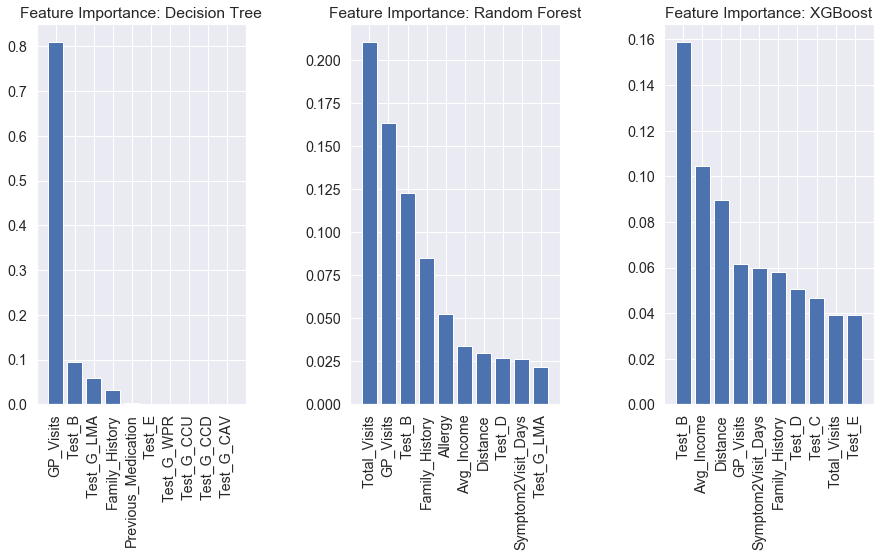

Num Features: 2
Selected Features: [False False False  True False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
Feature Ranking: [ 25  50  15   1  77  28  78  14   8  29  13  19   1   9  

In [39]:
# Feature Selection: Feature Importance #
#########################################
# Write a function F.I.P plot #
# Top 10 features:
def fip_plot(model):
    model = model
    model.fit(X_train_std, y_train)
    feat_labels = df_transformed.columns[:-1]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][0:10]

    #for f in range(10):
        #print("%2d) %-*s %f" % (f + 1, 30, 
                            #feat_labels[indices[f]],
                            #importances[indices[f]]))

    plt.bar(range(10), importances[indices], align='center')
    plt.xticks(range(10), feat_labels[indices], rotation=90)
    plt.xlim(-1, 10)

plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.5)

# Using a Decision Tree:
plt.subplot(1,3,1)
fip_plot(DecisionTreeClassifier(criterion='gini',
                                max_depth=4,
                                random_state=0))
plt.title('Feature Importance: Decision Tree')

# Using a Random Forest:
plt.subplot(1,3,2)
fip_plot(RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=0,
                                n_jobs=1))
plt.title('Feature Importance: Random Forest')

# Using a XGBoost:
plt.subplot(1,3,3)
fip_plot(XGBClassifier(n_estimators=100,
                    random_state=0,
                    n_jobs=1,
                    learning_rate=0.2))
plt.title('Feature Importance: XGBoost')
plt.show()     

# Feature Selection: Recursive Feature Elimination #
###############################################################################
# Using Logistic Regression: 
lr = LogisticRegression(random_state=0)
from sklearn.feature_selection import RFE
rfe = RFE(lr, 2) 
rfe.fit(X_train_std, y_train)
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

### Decision Boundary: ML Classifications ###
Visualize decision boundaries for top two selected features on all four classifiers. Following decision boundary plots were plotted to show how well ED admitted cases were separated from non-ED admitted cases:

* Logistic Regression: GP visits vs. Previous Med [standardized]
* K-Nearest Neighbors: GP visits vs. Previous Med [standardized]
* Support Vector Machine: GP visits vs. Previous Med [standardized]
* Decision Tree: GP Visits vs. Test_B [standardized]
* Random Forest: GP Visits vs. Total Visits [standardized]
* XGBoost: Test_B vs. Average Income [standardized]

In [40]:
# Model Fitting for Decision Boundary Plots #
##############################
# Model: Logistic Regression #
##############################
# Input feature selection: GP_Visits, Family_History 
X_train_lr = X_train_std[:, [3,12]]
y_train_lr = y_train

# Model fitting:
lr = LogisticRegression(C=0.1, penalty='l1', random_state=0)
lr.fit(X_train_lr, y_train_lr)

# Model prediction: test set
X_test_lr = X_test_std[:, [3,12]]
y_pred_test_lr = lr.predict(X_test_lr)  

##############################
# Model: K-Nearest Neighbors #
##############################
# Input feature selection: GP_Visits, Family_History 
X_train_knn = X_train_std[:, [3,12]]
y_train_knn = y_train

# Model fitting:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

# Model prediction: test set
X_test_knn = X_test_std[:, [3,12]]
y_pred_test_knn = knn.predict(X_test_knn)

################################
# Model: SupportVector Machine #
################################
# Input feature selection: GP_Visits, Family_History 
X_train_svm = X_train_std[:, [3,12]]
y_train_svm = y_train

# Model fitting:
svm = SVC(C=1.0, random_state=1, probability=True)
svm.fit(X_train_svm, y_train_svm)

# Model prediction: test set
X_test_svm = X_test_std[:, [3,12]]
y_pred_test_svm = svm.predict(X_test_knn)

########################
# Model: Decision Tree #
########################
# Input feature selection: GP_Visits, Test_B 
X_train_dt = X_train_std[:, [7,14]]
y_train_dt = y_train

# Model fitting:
tree = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree.fit(X_train_dt, y_train_dt)

# Model prediction: test set
X_test_dt = X_test_std[:, [7,14]]
y_pred_test_dt = tree.predict(X_test_dt)

########################
# Model: Random Forest #
########################
# Input feature selection: GP_Visits, Total_Visits
X_train_rf = X_train_std[:, [3,7]]
y_train_rf = y_train

# Model fitting:
forest = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest.fit(X_train_rf, y_train_rf)

# Model prediction: test set
X_test_rf = X_test_std[:, [3,7]]
y_pred_test_rf = forest.predict(X_test_rf)

##################
# Model: XGBoost #
##################
# Input feature selection: Avg_Income, Test_B
X_train_xgb = X_train_std[:, [1,14]]
y_train_xgb = y_train

# Model fitting:
xgb = XGBClassifier(n_estimators=50, learning_rate=0.2,
                       max_depth=1, random_state=0, n_jobs=1)
xgb.fit(X_train_xgb, y_train_xgb)

# Model prediction: test set
X_test_xgb = X_test_std[:, [1,14]]
y_pred_test_xgb = xgb.predict(X_test_xgb)

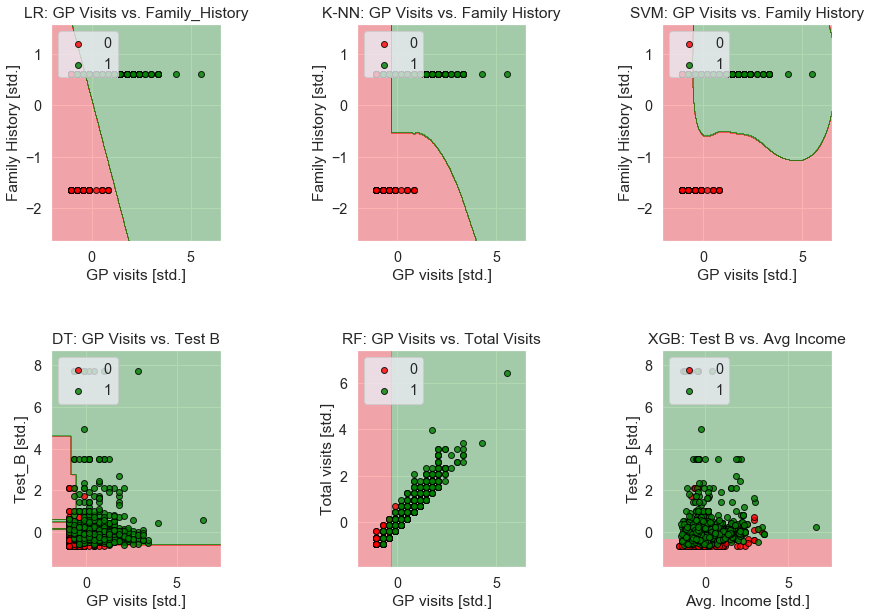

In [41]:
###########################################
# Decision Boundary Plots: ML Classifiers #
###########################################
# Write plot_decision_regions function #
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and colormap
    markers = ('o','o','s','^','v')
    colors = ('red','green','blue','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot decision surface
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

# Visualize stroke classification: Logistic Regression #
###############################################################################
# hold-out test set
plt.figure(figsize=(14,10))
plt.subplots_adjust(hspace=0.5, wspace=0.8)
plt.subplot(2,3,1)
plot_decision_regions(X_test_lr, y_test, classifier=lr, test_idx=None)
plt.title('LR: GP Visits vs. Family_History')
plt.xlabel('GP visits [std.]')
plt.ylabel('Family History [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: K-Nearest Neighbors #
###############################################################################
# hold-out test set
plt.subplot(2,3,2)
plot_decision_regions(X_test_knn, y_test, classifier=knn, test_idx=None)
plt.title('K-NN: GP Visits vs. Family History')
plt.xlabel('GP visits [std.]')
plt.ylabel('Family History [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: Support Vector Machine #
###############################################################################
# hold-out test set
plt.subplot(2,3,3)
plot_decision_regions(X_test_svm, y_test, classifier=svm, test_idx=None)
plt.title('SVM: GP Visits vs. Family History')
plt.xlabel('GP visits [std.]')
plt.ylabel('Family History [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: Decision Tree #
###############################################################################
# hold-out test set
plt.subplot(2,3,4)
plot_decision_regions(X=X_test_dt, y=y_test, classifier=tree, test_idx=None)
plt.title('DT: GP Visits vs. Test B')
plt.xlabel('GP visits [std.]')
plt.ylabel('Test_B [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: Random Forest #
###############################################################################
# hold-out test set
plt.subplot(2,3,5)
plot_decision_regions(X=X_test_rf, y=y_test, classifier=forest, test_idx=None)
plt.title('RF: GP Visits vs. Total Visits')
plt.xlabel('GP visits [std.]')
plt.ylabel('Total visits [std.]')
plt.legend(loc='upper left')

# Visualize stroke classification: XGBoost #
###############################################################################
# hold-out test set
plt.subplot(2,3,6)
plot_decision_regions(X=X_test_xgb, y=y_test, classifier=xgb, test_idx=None)
plt.title('XGB: Test B vs. Avg Income')
plt.xlabel('Avg. Income [std.]')
plt.ylabel('Test_B [std.]')
plt.legend(loc='upper left')
plt.show()        

### K-fold Cross Validation ###

Stratified k-fold cross validation was used for model validation by optimizing model hyperparameters. Firstly, earlier training set portion was used to divide data into multiple folds. In each iteration, one fold was used as validation fold and remaining folds were used for training. Note that this procedures were repeated "k" times and validation fold was shuffled between each iteration. Finally, model performance across all iterations were averaged to provide the best model hyperparameters.

In [42]:
# Feature Selection:
# Avg_Income, Distance, GP_Visits, Total_Visits, Allergy, Fam_History, Test_B 
# 1, 2, 3, 7, 10, 12, 14

# Define top common selected input features:
X_cm, y_cm = X_train_std[:, [1,2,3,7,10,12,14]], y_train

# K-fold Cross-validation: Stratified #
skf = StratifiedKFold(n_splits=4, random_state=0)
for train_index, val_index in skf.split(X_cm, y_cm):
  #   print("TRAIN:", train_index,  "VALIDATE:", val_index)
    X_train_cm, X_val_cm = X_cm[train_index], X_cm[val_index]
    y_train_cm, y_val_cm = y_cm[train_index], y_cm[val_index]

# Define common test set:
X_test_cm = X_test_std[:, [1,2,3,7,10,12,14]]  

### Model Evaluation: using Feature Selection ###
Compute a normalized confusion matrix and classification metrics on following models:
* Logistic Regression
* K-NN Classifier
* SVM Classifier
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

### Model 1: Logistic Regression ###
Logistic regression is an algorithm where input features get transformed via the sigmoid logit function: odds ratio of logarithmic probabilty of an event occurring (i.e., ED admitted cases over non-ED admitted cases). Thus, output value will be ranged from (0,1). Logistic regression works well on linearly separable classes problem.

In [43]:
##############################
# Model: Logistic Regression #
##############################
lr_cv = LogisticRegression(C=0.1,penalty='l1',random_state=0)
lr_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: LogisticRegression #
# Create hyperparameter options:
param_dist = dict(C=randint(2,100), penalty=['l1','l2'])
random_search = RandomizedSearchCV(estimator=lr_cv, param_distributions=param_dist,
                                   random_state=0, n_iter=100, cv=4)
random_search_lr = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best Penalty:', random_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', random_search_lr.best_estimator_.get_params()['C'])

# Model prediction: test set
X_test_lr = X_test_cm
y_pred_test_lr = random_search_lr.predict(X_test_lr)

# Model predition probabilities: test set
y_pred_prob_test_lr = random_search_lr.predict_proba(X_test_lr)[:,1]    

Best Penalty: l2
Best C: 6


### Model 2: K-Nearest Neighbors (K-NN) ###
K-NN is a non-parametric lazy learning algorithm. Where it uses pattern in data to place new data points for relevant categories/classes. The algorithm works by performing calculation of Euclidean distance between existing points and new data point. Thus, assigns new data point to a class with most k-Neighbors.

In [44]:
##############################
# Model: K-Nearest Neighbors #
##############################
knn_cv = KNeighborsClassifier(n_neighbors=5)
knn_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: K-NN #
# Create hyperparameter options:
param_dist = dict(n_neighbors=randint(1,10), leaf_size=randint(10,40), algorithm=['auto','brute'])
random_search = RandomizedSearchCV(estimator=knn_cv, param_distributions=param_dist,
                                   random_state=0, n_iter=100, cv=4)
random_search_knn = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best neighbors:', random_search_knn.best_estimator_.get_params()['n_neighbors'])
print('Best leaf_size:', random_search_knn.best_estimator_.get_params()['leaf_size'])
print('Best algorithm:', random_search_knn.best_estimator_.get_params()['algorithm'])

# Model prediction: test set
X_test_knn = X_test_cm
y_pred_test_knn = random_search_knn.predict(X_test_knn)

# Model predition probabilities: test set
y_pred_prob_test_knn = random_search_knn.predict_proba(X_test_knn)[:,1]    

Best neighbors: 5
Best leaf_size: 28
Best algorithm: brute


### Model 3: Support Vector Machine (SVM) ###
SVM is a type of marginal classifier algorithm. The main objective of this algorithm is to draw decision boundary between two hyperplanes (positive and negative) to classify class label(s) of training samples.

In [45]:
###################################
# Model 3: Support Vector Machine #
###################################
svm_cv = SVC(C=1.0, random_state=1, probability=True)
svm_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: SVM #
# Create hyperparameter options:
param_dist = dict(C=randint(1,10), gamma=np.arange(0,1,0.1), kernel=['linear','rbf'])
random_search = RandomizedSearchCV(estimator=svm_cv, param_distributions=param_dist,
                                   random_state=0, n_iter=100, cv=4)
random_search_svm = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best C:', random_search_svm.best_estimator_.get_params()['C'])
print('Best gamma:', random_search_svm.best_estimator_.get_params()['gamma'])
print('Best kernel:', random_search_svm.best_estimator_.get_params()['kernel'])

# Model prediction: hold-out test set
X_test_svm = X_test_cm
y_pred_test_svm = random_search_svm.predict(X_test_svm)

# Model predition probabilities: test set
y_pred_prob_test_svm = random_search_svm.predict_proba(X_test_svm)[:,1]    

Best C: 8
Best gamma: 0.2
Best kernel: rbf


### Model 4: Decision Tree ###
Decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. A tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to same class either non-ED admitted or ED admitted cases only).

In [46]:
####################################
# Model 4: DecisionTree Classifier #
####################################
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_dt = {"criterion": ["gini", "entropy"],
                  "max_depth": randint(10, 100),
                  "max_leaf_nodes": randint(10, 20),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10)}
random_search = RandomizedSearchCV(estimator=tree_cv, param_distributions=param_dist_dt,
                                   random_state=0, n_iter=100, cv=4)
random_search_dt = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])

# Model prediction: CV testset
X_test_dt = X_test_cm
y_pred_test_dt = random_search_dt.predict(X_test_dt)

# Model predition probabilities: test set
y_pred_prob_test_dt = random_search_dt.predict_proba(X_test_dt)[:,1]    

Best min_samples_split: 5
Best min_samples_leaf: 4
Best max_depth: 57


### Model 5: Random Forest ###
Random forest is a typical ensemble learning model. It takes random subsample of data from each tree, so all constructed trees are different from each other. Thus, model makes classification based on predictions made from each tree with averaging (i.e., like picking a vote from majority).

In [47]:
####################################
# Model 5: RandomForest Classifier #
####################################
forest_cv = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_rf = {'n_estimators': randint(20,200),
                'max_depth': randint(10,100),
                'min_samples_split': randint(2,10),
                'min_samples_leaf': randint(2,10),
                'bootstrap': [True, False],
                'criterion': ['gini','entropy']}
random_search = RandomizedSearchCV(estimator=forest_cv, param_distributions=param_dist_rf,
                                  random_state=0, n_iter=100, cv=4)
random_search_rf = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

# Model prediction: CV testset
X_test_rf = X_test_cm
y_pred_test_rf = random_search_rf.predict(X_test_rf)

# Model predition probabilities: test set
y_pred_prob_test_rf = random_search_rf.predict_proba(X_test_rf)[:,1]    

Best n_estimators: 37
Best max_depth: 48
Best min_samples_split: 6
Best min_samples_leaf: 2


### Model 6: XGBoost ###
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how XGBoost to improve model performances.

In [48]:
####################################
# Model 6: XGBoost Classifier #
####################################
xgb_cv = XGBClassifier(n_estimators=50, learning_rate=0.2,
                       max_depth=1, random_state=0, n_jobs=1)
xgb_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_xgb = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "learning_rate": np.random.uniform(0,1,10),
                  "objective": ['binary:logistic','reg:linear'],
                  "booster": ['gbtree','gblinear']}
random_search = RandomizedSearchCV(estimator=xgb_cv, param_distributions=param_dist_xgb,
                                   random_state=0, n_iter=100, cv=4)
random_search_xgb = random_search.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])
print('Best booster:', random_search_xgb.best_estimator_.get_params()['booster'])

# Model prediction: hold-out test set
X_test_xgb = X_test_cm
y_pred_test_xgb = random_search_xgb.predict(X_test_xgb)

# Model predition probabilities: test set
y_pred_prob_test_xgb = random_search_xgb.predict_proba(X_test_xgb)[:,1]    

Best n_estimators: 102
Best max_depth: 77
Best learning_rate: 0.699035428402
Best objective: binary:logistic
Best booster: gbtree


## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

1. True Positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): We predicted no, and they don't have the disease.
3. False Positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

In [49]:
# Making the Confusion/Contingency Matrix #
#############################################################################
# Write plot_confusion_matrix function #
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots(figsize=(5,5))
    cm = cm.astype('float') / cm.sum()
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')    
        
    #plt.tight_layout()
    plt.xlabel('predicted label')
    plt.ylabel('true label')


# Make class labels for "admit flag"
class_labels = np.array(['non-ED admitted','ED admitted'], dtype=str)   

# Write a function: report classification metrics
###############################################################################
def rep_class_metrics(y_act, y_pred, model_name):
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_act, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_act, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_act, y_pred))

# Write a function: report roc_auc score
def rep_roc_auc_score(y_act, y_pred_prob, model_name):
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_act, y_pred_prob))

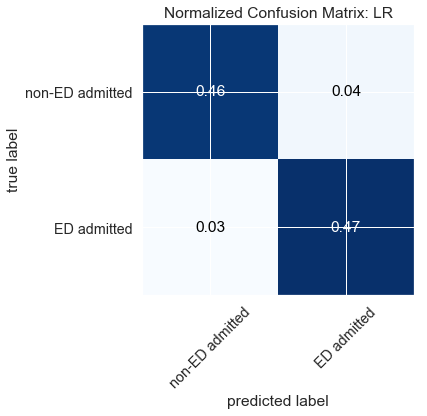

Accuracy of LogisticRegression is 0.93
Precision of LogisticRegression is 0.92
Recall of LogisticRegression is 0.94
ROC score of LR Test is 0.98


In [50]:
# Plot confusion matrix on test set: Logistic Regression
###############################################################################
cm_test_lr = skm.confusion_matrix(y_test, y_pred_test_lr)
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_lr, class_labels)
plt.title('Normalized Confusion Matrix: LR')
plt.show()

# Classification metrics on test set: LogisticRegression
rep_class_metrics(y_test, y_pred_test_lr, 'LogisticRegression')
rep_roc_auc_score(y_test, y_pred_prob_test_lr, 'LR Test')

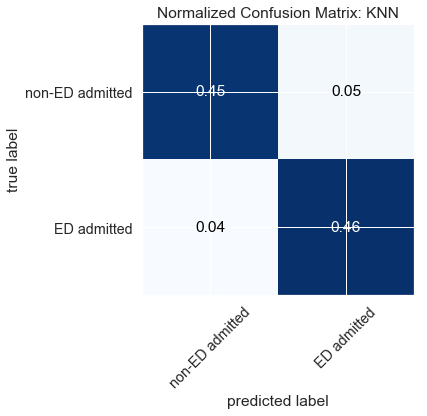

Accuracy of K-NearestNeighbors is 0.92
Precision of K-NearestNeighbors is 0.91
Recall of K-NearestNeighbors is 0.93
ROC score of KNN Test is 0.95


In [51]:
# Plot confusion matrix on test set: K-Nearest Neighbors
###############################################################################
cm_test_knn = skm.confusion_matrix(y_test, y_pred_test_knn)
np.set_printoptions(precision=3)  

plot_confusion_matrix(cm_test_knn, class_labels)
plt.title('Normalized Confusion Matrix: KNN')
plt.show()

# Classification metrics on test set: KNearestNeighbors
rep_class_metrics(y_test, y_pred_test_knn, 'K-NearestNeighbors')
rep_roc_auc_score(y_test, y_pred_prob_test_knn, 'KNN Test')

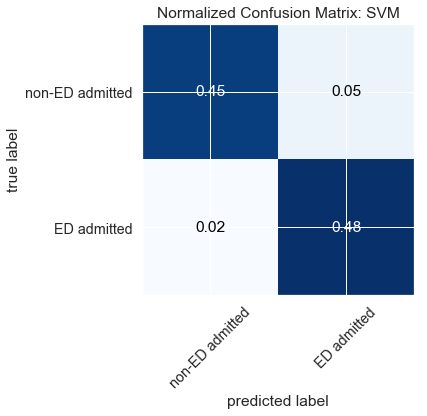

Accuracy of SV Machine is 0.93
Precision of SV Machine is 0.91
Recall of SV Machine is 0.96
ROC score of SVM Test is 0.96


In [52]:
# Plot confusion matrix on test set: Support Vector Machine
###############################################################################
cm_test_svm = skm.confusion_matrix(y_test, y_pred_test_svm)
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_svm, class_labels)
plt.title('Normalized Confusion Matrix: SVM')
plt.show()

# Classification metrics on test set: SupportVector Machine
rep_class_metrics(y_test, y_pred_test_svm, 'SV Machine')
rep_roc_auc_score(y_test, y_pred_prob_test_svm, 'SVM Test')

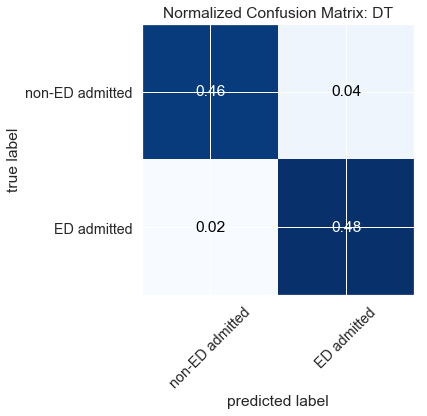

Accuracy of Decision Tree is 0.94
Precision of Decision Tree is 0.92
Recall of Decision Tree is 0.96
ROC score of DT Test is 0.96


In [53]:
# Plot confusion matrix on test set: DecisionTree
###############################################################################
cm_test_dt = skm.confusion_matrix(y_test, y_pred_test_dt)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_dt, class_labels)
plt.title('Normalized Confusion Matrix: DT')
plt.show()

# Classification metrics on test set: DecisionTree
rep_class_metrics(y_test, y_pred_test_dt, 'Decision Tree')
rep_roc_auc_score(y_test, y_pred_prob_test_dt, 'DT Test')

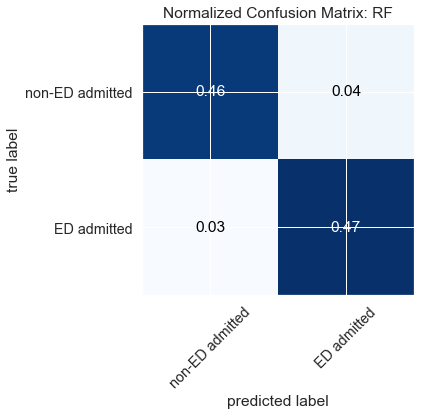

Accuracy of Random Forest is 0.93
Precision of Random Forest is 0.92
Recall of Random Forest is 0.95
ROC score of RF Test is 0.97


In [54]:
# Plot confusion matrix on test set: RandomForest
###############################################################################
cm_test_rf = skm.confusion_matrix(y_test, y_pred_test_rf)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_rf, class_labels)
plt.title('Normalized Confusion Matrix: RF')
plt.show()

# Classification metrics on test set: RandomForest
rep_class_metrics(y_test, y_pred_test_rf, 'Random Forest')
rep_roc_auc_score(y_test, y_pred_prob_test_rf, 'RF Test')

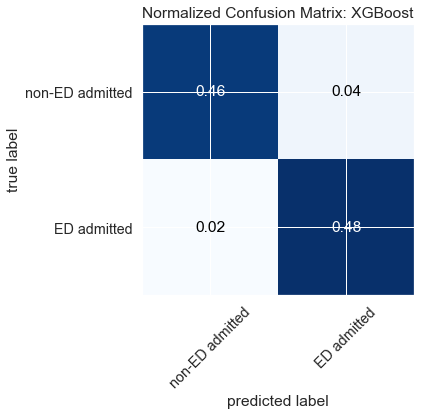

Accuracy of XGBoost is 0.93
Precision of XGBoost is 0.92
Recall of XGBoost is 0.95
ROC score of XGB Test is 0.97


In [55]:
# Plot confusion matrix on test set: XGBoost
###############################################################################
cm_test_xgb = skm.confusion_matrix(y_test, y_pred_test_xgb) 
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Classification metrics on test set: XGBoost
rep_class_metrics(y_test, y_pred_test_xgb, 'XGBoost')
rep_roc_auc_score(y_test, y_pred_prob_test_xgb, 'XGB Test')

### Model Evaluation: precision-recall curve ###
Precision-Recall is a useful measure of success for predictions when the classes of dataset are highly imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall at different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In summary, a system with high recall but low precision returns: many predictions where most of prediction results are incorrect when compared to actual true labels. Conversely, a system with low recall and high precision returns: few predictions but most of its prediction results are correct when compared to actual true labels.

Average precision-recall score of XGB model: 0.97


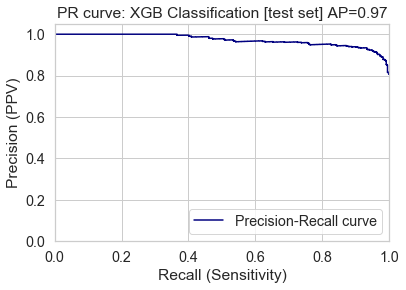

In [56]:
############################################
# Model Evaluation: Precision Recall Curve #
############################################
# Compute average precision score: best model
###############################################################################
y_score_xgb = random_search_xgb.fit(X_train_cm,y_train_cm).predict_proba(X_test_cm)[:,1]
avg_precision = skm.average_precision_score(y_test, y_score_xgb)

print('Average precision-recall score of XGB model: {0:0.2f}'.format(
      avg_precision))

# Plot Precision-Recall curve:
###############################################################################
precision, recall, _ = skm.precision_recall_curve(y_test, y_score_xgb)

sns.set_style('whitegrid')

plt.step(recall, precision, color='navy', where='post',label='Precision-Recall curve')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='navy')
plt.title('PR curve: XGB Classification [test set] AP={0:0.2f}'
          .format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

### Summary of Precision-Recall Curve ###
Overall, the XGB classifier showed the best weighted average precision of 0.97. In other words, about 97% of time, the model is good at making ED admission predictions from total # of actual ED admitted cases.

### Model Evaluation: ROC curve ###
ROC curve typically displays true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

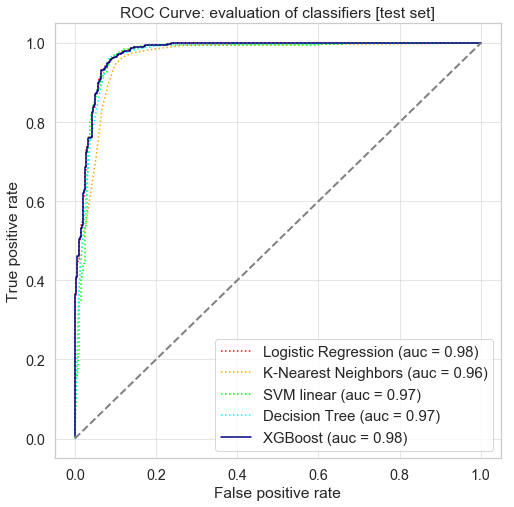

In [57]:
###################################
# Model Evaluation: ROC-AUC Curve #
###################################
# All labels and trained classifiers # 
######################################
clf_labels = ['Logistic Regression', 'K-Nearest Neighbors', 'SVM linear', 
              'Decision Tree', 'XGBoost']
all_clf = [random_search_lr, random_search_knn, random_search_svm,
           random_search_dt, random_search_xgb]
# 'Random Forest', random_search_rf

# Plot a ROC Curve #
######################################
plt.figure(figsize=(8,8))
# ROC for each classifiers
colors = ['red', 'orange', 'lime', 'cyan', 'navy', 'purple']
linestyles = [':', ':', ':', ':', '-']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
        # Asumming the label of the positive class is 1
        y_pred = clf.fit(X_train_cm,
                         y_train_cm).predict_proba(X_test_cm)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_test,
                                         y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (auc = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1],linestyle='--',color='gray',linewidth=2)    
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: evaluation of classifiers [test set]')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

### Summary of ROC Curve ###
Overall, top 2 classifiers showed mean AUC of 0.98. These models were Logistic Regression and XGBoost classifiers. In summary, about 98% of time these models were good at separating ED admitted predictions fron non-ED admitted predictions .